In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_pickle('./florida_rent_data.pkl')

In [4]:
df

,bathrooms,bedrooms,price,square_feet,cityname,state,latitude,longitude,region,cnt_nearby_hospitals,cnt_nearby_school,cnt_nearby_libraries
30,2.0,2.0,1740.0,1600,West Palm Beach,FL,26.7173,-80.1164,South,0,0,1
54,1.0,1.0,973.0,509,Orlando,FL,28.5163,-81.3644,South,0,0,0
63,2.0,3.0,1499.0,1544,Jacksonville,FL,30.2989,-81.6324,South,0,0,0
69,1.0,1.0,1055.0,550,Saint Petersburg,FL,27.7873,-82.6772,South,0,0,1
114,1.0,1.0,949.0,625,Tallahassee,FL,30.4601,-84.2714,South,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99795,1.0,1.0,1390.0,848,Jacksonville,FL,30.3034,-81.5127,South,0,0,0
99799,2.0,2.0,1402.0,1245,Jacksonville,FL,30.3034,-81.5127,South,0,0,0
99804,1.0,1.0,1550.0,942,Jacksonville,FL,30.3034,-81.5127,South,0,0,0
99820,1.0,1.0,798.0,650,Jacksonville,FL,30.2254,-81.7579,South,0,0,0


<Axes: xlabel='price', ylabel='Count'>

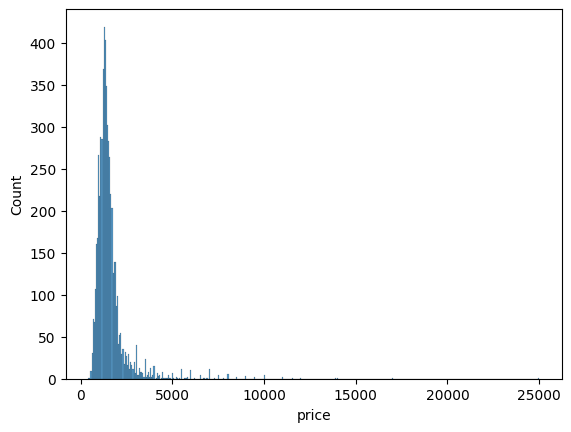

In [5]:
sns.histplot(data = df, x = df['price'])

In [6]:
def take_outliers(df, column):
    # Calculate the first quartile (Q1) and third quartile (Q3) of the price data
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    # Define the lower and upper bounds to filter out outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter out prices outside of the IQR range
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    print("Original DataFrame:")
    print(df.shape)
    print("\nFiltered DataFrame (prices within the IQR range):")
    print(filtered_df.shape)
    return filtered_df

In [7]:
filtered_df = take_outliers(df,'price')
filtered_df = take_outliers(filtered_df,'square_feet')

Original DataFrame:
(5779, 12)

Filtered DataFrame (prices within the IQR range):
(5346, 12)
Original DataFrame:
(5346, 12)

Filtered DataFrame (prices within the IQR range):
(5216, 12)


<Axes: xlabel='price', ylabel='Count'>

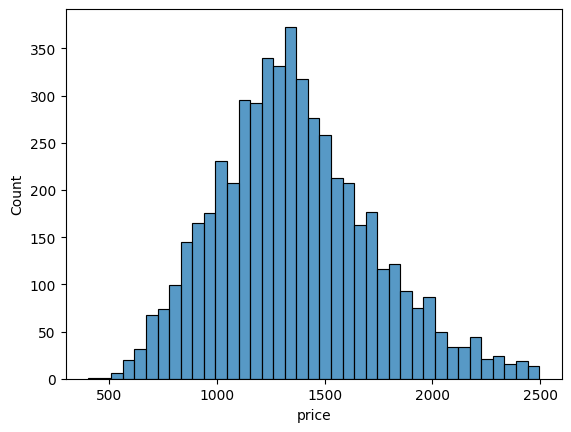

In [8]:
sns.histplot(data = filtered_df, x = filtered_df['price'])

In [9]:
florida_numeric = filtered_df.select_dtypes(include='number')

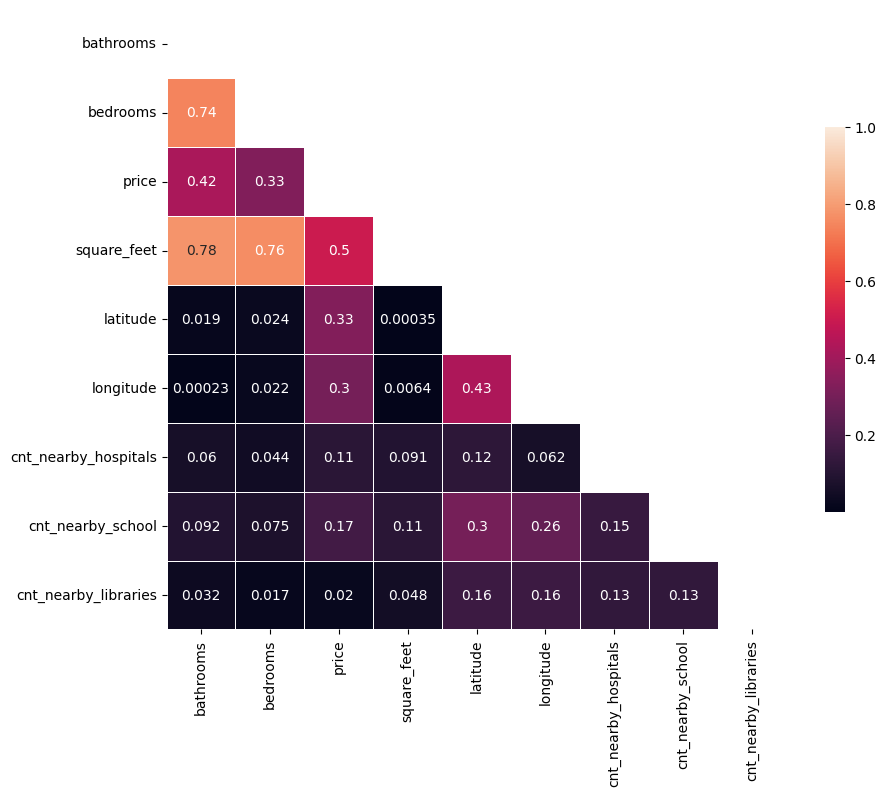

In [10]:
corr=np.abs(florida_numeric.corr())

#Set up mask for triangle representation (so it only shows one side)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [11]:
filtered_df.dtypes

bathrooms               float64
bedrooms                float64
price                   float64
square_feet               int32
cityname                 object
state                    object
latitude                float64
longitude               float64
region                   object
cnt_nearby_hospitals      int64
cnt_nearby_school         int64
cnt_nearby_libraries      int64
dtype: object

In [12]:
filtered_df.drop(columns=['state', 'region', ], inplace=True)

In [13]:
filtered_df['cityname'].value_counts()

cityname
Tampa               776
Bradenton           332
Orlando             300
Saint Petersburg    267
Kissimmee           252
                   ... 
Wauchula              1
Lake Wales            1
Fort Myers Beach      1
Lithia                1
Cape Canaveral        1
Name: count, Length: 169, dtype: int64

In [14]:
cities = [
    'West Palm Beach', 'Orlando', 'Jacksonville', 'Saint Petersburg',
    'Tallahassee', 'Gainesville', 'Tampa', 'Cocoa Beach',
    'Miami Beach', 'Winter Garden', 'Fernandina Beach',
    'Altamonte Springs', 'Lady Lake', 'Sarasota', 'Miami',
    'Fort Pierce', 'Ruskin', 'Venice', 'Spring Hill', 'Fort Myers',
    'Apopka', 'Naples', 'Longwood', 'Oviedo', 'Palm Coast',
    'Westchase', 'Riverview', 'Fort Lauderdale', 'Holly Hill',
    'Brandon', 'Valrico', 'Pensacola', 'Winter Park', 'Kissimmee',
    'Destin', 'Saint Cloud', 'Davenport', 'Vero Beach',
    'Fort Walton Beach', 'Doral', 'Lutz', 'Odessa', 'Ocala',
    'Chiefland', 'North Miami', 'Saint Augustine', 'Pembroke Pines',
    'Clearwater', 'Plant City', 'Port Orange', 'Port Richey',
    'Maitland', 'Daytona Beach', 'Jupiter', 'Panama City Beach',
    'Bradenton', 'Ponte Vedra', 'North Fort Myers', 'Coral Gables',
    'Deltona', 'Port Saint Lucie', 'Sebastian', 'Tarpon Springs',
    'Wilton Manors', 'Celebration', 'Orange Park', 'New Port Richey',
    'Sanford', 'Lake Worth', 'Niceville', 'Boca Raton', 'Saint Johns',
    'Dania Beach', 'Wesley Chapel', 'Wimauma', 'Winter Springs',
    'Clermont', 'Oakland Park', 'Homestead', 'Hollywood', 'Opa Locka',
    'Pompano Beach', 'Key Biscayne', 'Cutler Bay', 'Englewood',
    'Cape Coral', 'Coral Springs', 'Lauderhill', 'Cutler Ridge',
    'Palm Harbor', 'Windermere', 'North Port', 'Jensen Beach', 'Ocoee',
    'Leesburg', 'Dunedin', 'Brooksville', 'Stuart', 'Fruitland Park',
    'Holiday', 'Oxford', 'Dunnellon', 'Silver Springs', 'Ellenton',
    'Oldsmar', 'Homosassa', 'Longboat Key', 'Hudson', 'Land O Lakes',
    'Titusville', 'Haines City', 'Deerfield Beach', 'Sun City Center',
    'Marco Island', 'Parrish', 'Mims', 'Thonotosassa', 'Palmetto',
    'Navarre', 'Beverly Hills', 'Mulberry', 'Gulf Breeze',
    'South Pasadena', 'Englewood Beach', 'Green Cove Springs', 'Avon Park',
    'Inverness', 'Apollo Beach', 'Citrus Springs', 'Palm City', 'Lecanto',
    'Lake City', 'Belleview', 'Lake Mary', 'Rockledge', 'Lady Lake',
    'Port Charlotte', 'Viera', 'Sanford', 'Sebring', 'Perry', 'Midway',
    'Tavares', 'Atlantic Beach', 'Bunnell', 'Wauchula', 'Mount Dora',
    'Dade City', 'Eustis', 'Santa Rosa Beach', 'Atlantic Beach',
    'Ormond Beach', 'Hallandale', 'Newberry', 'Panama City',
    'New Smyrna Beach', 'Flagler Beach', 'Yulee', 'Deland',
    'Jacksonville Beach', 'The Villages', 'Merritt Island',
    'Dania', 'Ponte Vedra Beach', 'Cape Canaveral'
]
north_florida = [
    'Jacksonville', 'Tallahassee', 'Gainesville', 'Pensacola', 'Fernandina Beach',
    'Palm Coast', 'Saint Augustine', 'Lake City', 'Atlantic Beach', 'Flagler Beach',
    'Jacksonville Beach', 'Yulee'
]
central_florida = [
    'Orlando', 'Saint Petersburg', 'Tampa', 'Winter Garden', 'Altamonte Springs',
    'Lady Lake', 'Sarasota', 'Ruskin', 'Venice', 'Spring Hill', 'Apopka',
    'Longwood', 'Oviedo', 'Westchase', 'Riverview', 'Holly Hill', 'Brandon',
    'Valrico', 'Winter Park', 'Kissimmee', 'Saint Cloud', 'Davenport', 'Lutz',
    'Odessa', 'Ocala', 'Chiefland', 'Clearwater', 'Plant City', 'Port Orange',
    'Port Richey', 'Maitland', 'Daytona Beach', 'Ponte Vedra', 'Deltona',
    'Tarpon Springs', 'Celebration', 'Orange Park', 'New Port Richey', 'Sanford',
    'Lake Worth', 'Wesley Chapel', 'Winter Springs', 'Clermont', 'Ocoee', 'Leesburg',
    'Dunedin', 'Brooksville', 'Stuart', 'Fruitland Park', 'Holiday', 'Oxford',
    'Dunnellon', 'Silver Springs', 'Ellenton', 'Oldsmar', 'Hudson', 'Land O Lakes',
    'Titusville', 'Haines City', 'Sun City Center', 'Mims', 'Thonotosassa', 'Palmetto',
    'South Pasadena', 'Green Cove Springs', 'Apollo Beach', 'Belleview', 'Rockledge',
    'Lady Lake', 'Viera', 'Sebring', 'Mount Dora', 'Dade City', 'Eustis',
    'Ormond Beach', 'Newberry', 'Deland', 'The Villages', 'Merritt Island', 'Dania',
    'Cape Canaveral'
]
south_florida = [
    'Miami', 'West Palm Beach', 'Miami Beach', 'Fort Pierce', 'Fort Myers',
    'Naples', 'Fort Lauderdale', 'Doral', 'North Miami', 'Pembroke Pines',
    'Jupiter', 'Coral Gables', 'Port Saint Lucie', 'Sebastian', 'Wilton Manors',
    'Boca Raton', 'Dania Beach', 'Wimauma', 'Oakland Park', 'Homestead', 'Hollywood',
    'Opa Locka', 'Pompano Beach', 'Key Biscayne', 'Cutler Bay', 'Cape Coral',
    'Coral Springs', 'Lauderhill', 'Cutler Ridge', 'Palm Harbor', 'Windermere',
    'North Port', 'Jensen Beach', 'Englewood', 'Marco Island', 'Parrish', 'Haines City',
    'Deerfield Beach', 'Navarre', 'Beverly Hills', 'Gulf Breeze', 'Englewood Beach',
    'Inverness', 'South Pasadena', 'Mulberry', 'Palm City', 'Lecanto', 'Port Charlotte',
    'Sebring', 'Lake Mary', 'Midway', 'Viera', 'Sebring'
]
florida_panhandle = [
    'Panama City', 'Destin', 'Fort Walton Beach', 'Niceville', 'Santa Rosa Beach',
    'Panama City Beach'
]


In [15]:
# Create the classification function
def classify_city(city):
    if city in north_florida:
        return 'North Florida'
    elif city in central_florida:
        return 'Central Florida'
    elif city in south_florida:
        return 'South Florida'
    elif city in florida_panhandle:
        return 'Florida Panhandle'
    else:
        return 'Other'

In [16]:
# Apply the function to create a new column
filtered_df['state_region'] = filtered_df['cityname'].apply(classify_city)

In [17]:
filtered_df = pd.get_dummies(filtered_df, columns=['state_region'])
filtered_df

,bathrooms,bedrooms,price,square_feet,cityname,latitude,longitude,cnt_nearby_hospitals,cnt_nearby_school,cnt_nearby_libraries,state_region_Central Florida,state_region_Florida Panhandle,state_region_North Florida,state_region_Other,state_region_South Florida
30,2.0,2.0,1740.0,1600,West Palm Beach,26.7173,-80.1164,0,0,1,False,False,False,False,True
54,1.0,1.0,973.0,509,Orlando,28.5163,-81.3644,0,0,0,True,False,False,False,False
63,2.0,3.0,1499.0,1544,Jacksonville,30.2989,-81.6324,0,0,0,False,False,True,False,False
69,1.0,1.0,1055.0,550,Saint Petersburg,27.7873,-82.6772,0,0,1,True,False,False,False,False
114,1.0,1.0,949.0,625,Tallahassee,30.4601,-84.2714,0,1,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99795,1.0,1.0,1390.0,848,Jacksonville,30.3034,-81.5127,0,0,0,False,False,True,False,False
99799,2.0,2.0,1402.0,1245,Jacksonville,30.3034,-81.5127,0,0,0,False,False,True,False,False
99804,1.0,1.0,1550.0,942,Jacksonville,30.3034,-81.5127,0,0,0,False,False,True,False,False
99820,1.0,1.0,798.0,650,Jacksonville,30.2254,-81.7579,0,0,0,False,False,True,False,False


## Machine Learning

### Train and Test split

We are going to be doing two models experiments. One with all columns as features, and another one eliminating features that do not affect the target column (API data columns).

In [18]:
filtered_df = filtered_df.drop(columns=['cityname'])

In [19]:
features = filtered_df.drop(columns = ["price"])
target = filtered_df['price']

In [20]:
# This is the features dataframe excluding the API data as a feature
no_api_features = filtered_df.drop(columns = ["price", "cnt_nearby_hospitals", "cnt_nearby_school", "cnt_nearby_libraries"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(no_api_features, target, test_size = 0.20, random_state=0)

In [23]:
normalizer = MinMaxScaler()

normalizer.fit(X_train)

MinMaxScaler()

In [24]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [25]:
normalizer.fit(X_train2)

MinMaxScaler()

In [26]:
X_train_norm2 = normalizer.transform(X_train2)

X_test_norm2 = normalizer.transform(X_test2)

In [27]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,bathrooms,bedrooms,square_feet,latitude,longitude,cnt_nearby_hospitals,cnt_nearby_school,cnt_nearby_libraries,state_region_Central Florida,state_region_Florida Panhandle,state_region_North Florida,state_region_Other,state_region_South Florida
0,0.333333,0.50,0.590102,0.567591,0.649387,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1,0.333333,0.50,0.649112,0.731438,0.825656,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.50,0.623096,0.539745,0.635878,0.0,0.133333,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.25,0.470812,0.605133,0.806896,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
4,0.166667,0.25,0.496193,0.225287,0.964474,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
X_train_norm2 = pd.DataFrame(X_train_norm2, columns = X_train2.columns)
X_train_norm2.head()

,bathrooms,bedrooms,square_feet,latitude,longitude,state_region_Central Florida,state_region_Florida Panhandle,state_region_North Florida,state_region_Other,state_region_South Florida
0,0.333333,0.50,0.590102,0.567591,0.649387,1.0,0.0,0.0,0.0,0.0
1,0.333333,0.50,0.649112,0.731438,0.825656,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.50,0.623096,0.539745,0.635878,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.25,0.470812,0.605133,0.806896,1.0,0.0,0.0,0.0,0.0
4,0.166667,0.25,0.496193,0.225287,0.964474,0.0,0.0,0.0,1.0,0.0


In [29]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,bathrooms,bedrooms,square_feet,latitude,longitude,cnt_nearby_hospitals,cnt_nearby_school,cnt_nearby_libraries,state_region_Central Florida,state_region_Florida Panhandle,state_region_North Florida,state_region_Other,state_region_South Florida
0,0.500000,0.50,0.985406,0.329659,0.732656,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
1,0.333333,0.50,0.865482,0.751781,0.706283,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.75,0.701777,0.669145,0.841597,0.0,0.066667,0.0,1.0,0.0,0.0,0.0,0.0
3,0.000000,0.50,0.505076,0.603921,0.787862,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
4,0.000000,0.25,0.384518,0.939280,0.783437,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
X_test_norm2 = pd.DataFrame(X_test_norm2, columns = X_test2.columns)
X_test_norm2.head()

,bathrooms,bedrooms,square_feet,latitude,longitude,state_region_Central Florida,state_region_Florida Panhandle,state_region_North Florida,state_region_Other,state_region_South Florida
0,0.500000,0.50,0.985406,0.329659,0.732656,0.0,0.0,0.0,0.0,1.0
1,0.333333,0.50,0.865482,0.751781,0.706283,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.75,0.701777,0.669145,0.841597,1.0,0.0,0.0,0.0,0.0
3,0.000000,0.50,0.505076,0.603921,0.787862,1.0,0.0,0.0,0.0,0.0
4,0.000000,0.25,0.384518,0.939280,0.783437,0.0,0.0,1.0,0.0,0.0


## Linear Regression

In [31]:
lin_reg = LinearRegression()

In [32]:
lin_reg.fit(X_train_norm, y_train)

LinearRegression()

In [33]:
pred = lin_reg.predict(X_test_norm)

print("MAE", mean_absolute_error( y_test, pred))
print("RMSE", mean_squared_error(y_test, pred, squared=False))
print("R2 score", lin_reg.score(X_test_norm, y_test))

MAE 216.522030651341
RMSE 285.6568336804714
R2 score 0.41558561140888894


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
lin_reg.fit(X_train_norm2, y_train2)


LinearRegression()

In [35]:
pred2 = lin_reg.predict(X_test_norm2)

print("MAE", mean_absolute_error(pred2, y_test2))
print("RMSE", mean_squared_error(pred2, y_test2, squared=False))
print("R2 score", lin_reg.score(X_test_norm2, y_test2))

MAE 220.404214559387
RMSE 289.2262310708757
R2 score 0.40088937664868207


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [37]:
pred3 = lin_reg.predict(X_test)

print("MAE", mean_absolute_error(pred3, y_test))
print("RMSE", mean_squared_error(pred3, y_test, squared=False))
print("R2 score", lin_reg.score(X_test, y_test))

MAE 216.1887976365826
RMSE 285.2827253278243
R2 score 0.4171153569778423


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


After trying creating a Linear Regression with variations of our dataset, we can say that the best performing model was made out of training data that was not normalized using a scaler and it had the API data as a feature with r2 score of 0.42

## Random Forest

In [38]:
forest = RandomForestRegressor(n_estimators=100)

In [39]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
forest_pred = forest.predict(X_test)

print("MAE", mean_absolute_error(forest_pred , y_test))
print("RMSE", mean_squared_error(forest_pred , y_test, squared=False))
print("R2 score", forest.score(X_test, y_test))

r2 = forest.score(X_test, y_test)

MAE 125.2244938181107
RMSE 192.0536392670839
R2 score 0.7358341058309019


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


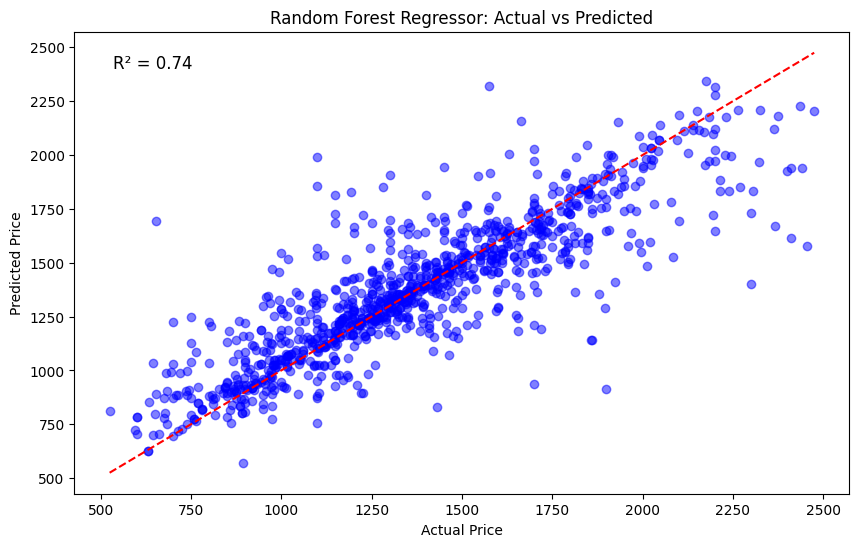

In [41]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, forest_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label=r2)
plt.title('Random Forest Regressor: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
# Add R² score to the plot
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()

## Bagging and Pasting

In [42]:
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [43]:
bagging_reg.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 max_samples=1000, n_estimators=100)

In [44]:
bagging_pred = bagging_reg.predict(X_test)

print("MAE", mean_absolute_error(bagging_pred, y_test))
print("RMSE", mean_squared_error(bagging_pred, y_test, squared=False))
print("R2 score", bagging_reg.score(X_test, y_test))

MAE 148.46131290970305
RMSE 206.26848714259899
R2 score 0.6952824761758476


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


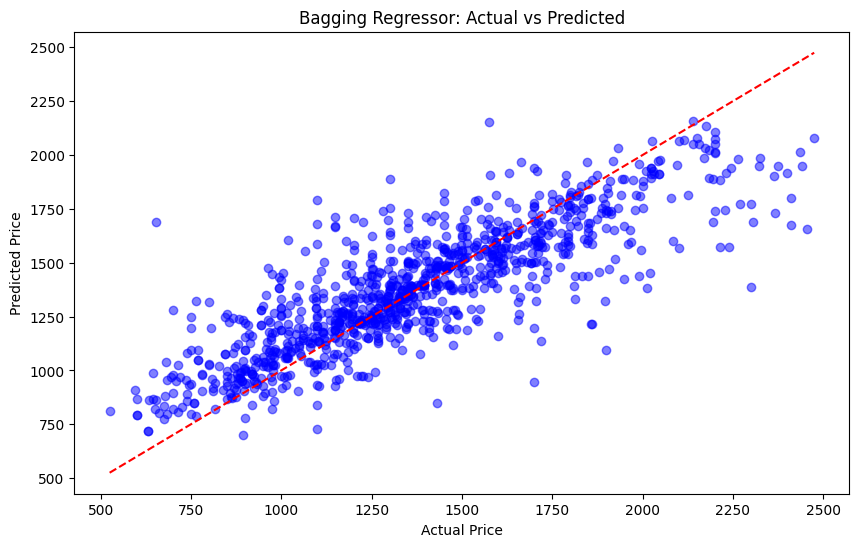

In [45]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, bagging_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Bagging Regressor: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## AdaBoost 

In [46]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)

In [47]:
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100)

In [48]:
ada_pred = ada_reg.predict(X_test)

print("MAE", mean_absolute_error(ada_pred, y_test))
print("RMSE", mean_squared_error(ada_pred, y_test, squared=False))
print("R2 score", ada_reg.score(X_test, y_test))

MAE 134.61018040636793
RMSE 196.62954772030963
R2 score 0.7230960031247543


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


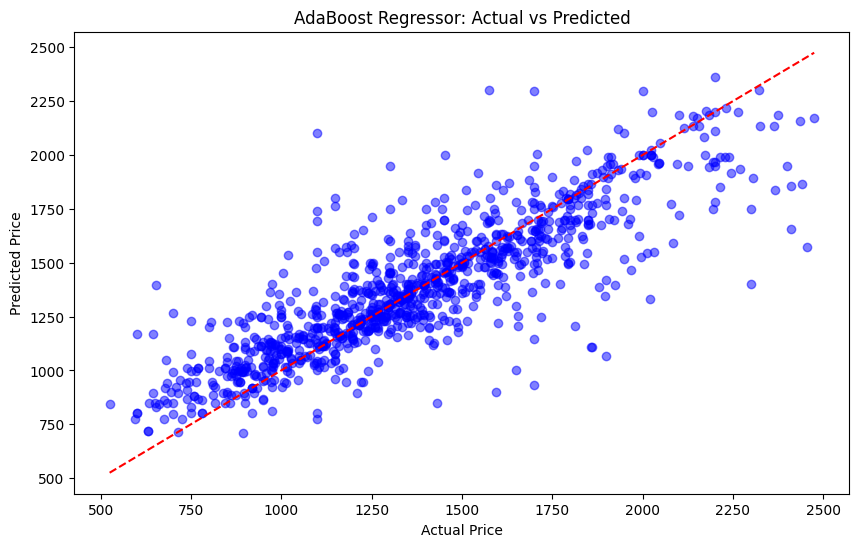

In [49]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ada_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('AdaBoost Regressor: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## Gradient Boosting

In [50]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)

In [51]:
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20)

In [52]:
gb_pred = gb_reg.predict(X_test)

print("MAE", mean_absolute_error(gb_pred, y_test))
print("RMSE", mean_squared_error(gb_pred, y_test, squared=False))
print("R2 score", gb_reg.score(X_test, y_test))

MAE 141.76925981369422
RMSE 232.93105614919494
R2 score 0.6114146210656988


c:\Users\aj824\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


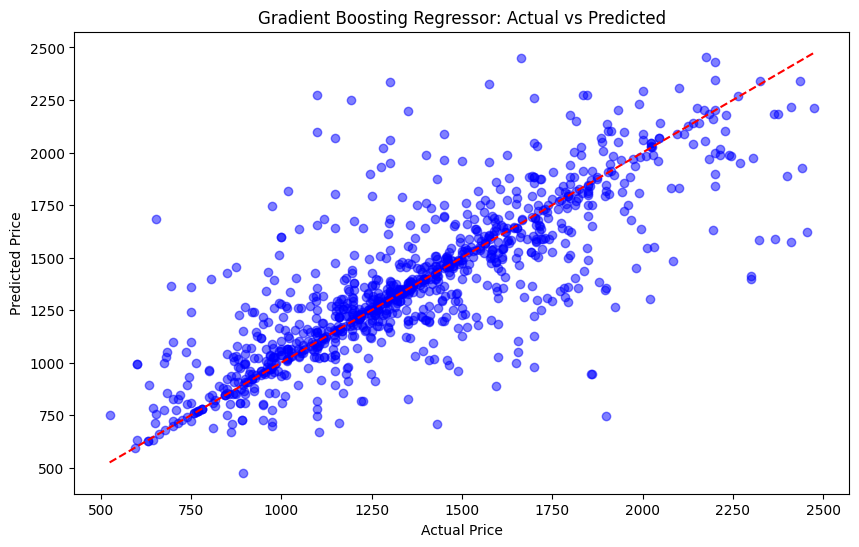

In [53]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Gradient Boosting Regressor: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

In [54]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 10)

knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.375913244307331

### Price Classification


In [55]:
filtered_df['price'].describe()

count    5216.000000
mean     1360.319785
std       360.086718
min       402.000000
25%      1113.000000
50%      1334.000000
75%      1580.000000
max      2495.000000
Name: price, dtype: float64

In [57]:
# Discretizing client age into 9 groups
# takes continuous variables and turns them in discreet variables by binning them
bins = [filtered_df['price'].min(), 1334.00, 1580.00, filtered_df['price'].max()]
labels = ['Low', 'Medium', 'High']
# create new column using the data above
filtered_df['rent_price_range'] = pd.cut(filtered_df['price'], bins=bins, labels=labels, include_lowest=True)
filtered_df.rent_price_range.value_counts()

rent_price_range
Low       2609
Medium    1309
High      1298
Name: count, dtype: int64

In [58]:
cs_features = filtered_df.drop(columns=['rent_price_range'])
cs_target = filtered_df['rent_price_range']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(cs_features, cs_target, test_size = 0.20, random_state=0)

In [62]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
forest_pred = forest.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, forest_pred))
print("F1 Score:", f1_score(y_test, forest_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, forest_pred))

Accuracy: 0.9961685823754789
F1 Score: 0.9961685823754789
Confusion Matrix:
 [[283   0   2]
 [  0 525   0]
 [  2   0 232]]
